<a href="https://colab.research.google.com/gist/dilithjay/5a15b87e3594b6c8eb995d12034a390f/custom-image-classification-with-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import glob
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image, ImageReadMode

# Datasets and Dataloaders

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['png', 'jpg']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        class_set = set()
        for path in self.image_paths:
            class_set.add(os.path.basename(os.path.dirname(path)))
        self.class_lbl = { cls: i for i, cls in enumerate(sorted(list(class_set)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]

        return self.transform(img), torch.tensor(label)

In [4]:
dataset = CustomDataset('images1/', transform)

In [5]:
splits = [0.8, 0.1, 0.1]
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)

In [6]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=8, shuffle=True),
    "test": DataLoader(test_set, batch_size=8, shuffle=False),
    "val": DataLoader(val_set, batch_size=8, shuffle=False)
}

# Model Definition

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [8]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(2048, 4)
model.to(device)
pass

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training

In [10]:
EPOCHS = 10
NUM_CLASSES = len(dataset.class_lbl)

In [11]:
dataset.class_lbl

{'masked': 0, 'masked_sunglasses': 1, 'neutral': 2, 'sunglasses': 3}

In [12]:
metrics = {
    'train': {'loss': [], 'accuracy': []},
    'val': {'loss': [], 'accuracy': []},
}

In [13]:
for epoch in range(EPOCHS):
  ep_metrics = {
    'train': {'loss': 0, 'accuracy': 0, 'count': 0},
    'val': {'loss': 0, 'accuracy': 0, 'count': 0},
  }

  print(f'Epoch {epoch}')

  for phase in ['train', 'val']:
    print(f'-------- {phase} --------')
    for images, labels in tqdm(dataloaders[phase]):
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels,
                                                num_classes=NUM_CLASSES)
        loss = criterion(output, ohe_label.float().to(device))

        correct_preds = labels.to(device) == torch.argmax(output, dim=1)
        accuracy = (correct_preds).sum()/len(labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

      ep_metrics[phase]['loss'] += loss.item()
      ep_metrics[phase]['accuracy'] += accuracy.item()
      ep_metrics[phase]['count'] += 1
  
    ep_loss = ep_metrics[phase]['loss']/ep_metrics[phase]['count']
    ep_accuracy = ep_metrics[phase]['accuracy']/ep_metrics[phase]['count']

    print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

    metrics[phase]['loss'].append(ep_loss)
    metrics[phase]['accuracy'].append(ep_accuracy)
  torch.save(model, "model_" + str(epoch) + ".pth")

Epoch 0
-------- train --------


  0%|          | 0/268 [00:00<?, ?it/s]c:\Users\yagya\AppData\Local\Continuum\anaconda3\envs\controlexpert\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 268/268 [01:34<00:00,  2.85it/s]


Loss: 0.46529847831089993, Accuracy: 0.8530783582089553

-------- val --------


100%|██████████| 34/34 [00:03<00:00, 11.00it/s]


Loss: 0.19583621610175161, Accuracy: 0.9448529411764706

Epoch 1
-------- train --------


100%|██████████| 268/268 [01:19<00:00,  3.35it/s]


Loss: 0.14378406033753904, Accuracy: 0.9598880597014925

-------- val --------


100%|██████████| 34/34 [00:02<00:00, 12.23it/s]


Loss: 0.16048620470032535, Accuracy: 0.9558823529411765

Epoch 2
-------- train --------


100%|██████████| 268/268 [01:13<00:00,  3.66it/s]


Loss: 0.08038536245815643, Accuracy: 0.976679104477612

-------- val --------


100%|██████████| 34/34 [00:02<00:00, 12.69it/s]


Loss: 0.22772446743157856, Accuracy: 0.9411764705882353

Epoch 3
-------- train --------


100%|██████████| 268/268 [01:19<00:00,  3.36it/s]


Loss: 0.06378933330003082, Accuracy: 0.9822761194029851

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  8.88it/s]


Loss: 0.2107380389728967, Accuracy: 0.9448529411764706

Epoch 4
-------- train --------


100%|██████████| 268/268 [01:24<00:00,  3.19it/s]


Loss: 0.042450192534502024, Accuracy: 0.9860074626865671

-------- val --------


100%|██████████| 34/34 [00:02<00:00, 12.09it/s]


Loss: 0.17740294516175603, Accuracy: 0.9669117647058824

Epoch 5
-------- train --------


100%|██████████| 268/268 [01:25<00:00,  3.14it/s]


Loss: 0.03943458816719436, Accuracy: 0.9874067164179104

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  9.61it/s]


Loss: 0.14082540984963998, Accuracy: 0.9632352941176471

Epoch 6
-------- train --------


100%|██████████| 268/268 [01:32<00:00,  2.90it/s]


Loss: 0.02593704499108821, Accuracy: 0.992070895522388

-------- val --------


100%|██████████| 34/34 [00:03<00:00, 11.11it/s]


Loss: 0.1743318470193224, Accuracy: 0.9705882352941176

Epoch 7
-------- train --------


100%|██████████| 268/268 [01:30<00:00,  2.97it/s]


Loss: 0.025113349694540592, Accuracy: 0.9925373134328358

-------- val --------


100%|██████████| 34/34 [00:02<00:00, 11.96it/s]


Loss: 0.18929061852566734, Accuracy: 0.9558823529411765

Epoch 8
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.03it/s]


Loss: 0.020289698810546413, Accuracy: 0.9939365671641791

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  9.02it/s]


Loss: 0.15382246023150134, Accuracy: 0.9632352941176471

Epoch 9
-------- train --------


100%|██████████| 268/268 [01:27<00:00,  3.07it/s]


Loss: 0.008649365231956753, Accuracy: 0.9976679104477612

-------- val --------


100%|██████████| 34/34 [00:03<00:00, 10.04it/s]


Loss: 0.19466439305303057, Accuracy: 0.9632352941176471



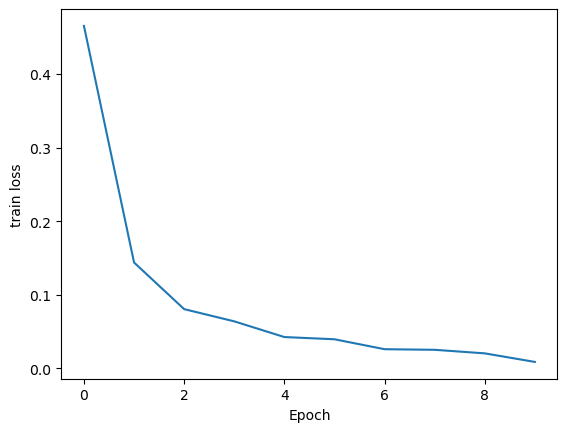

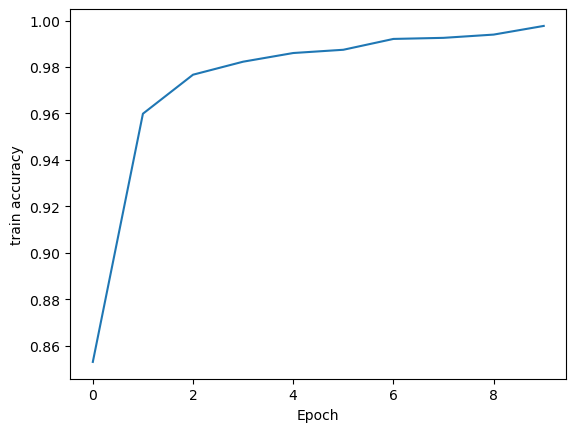

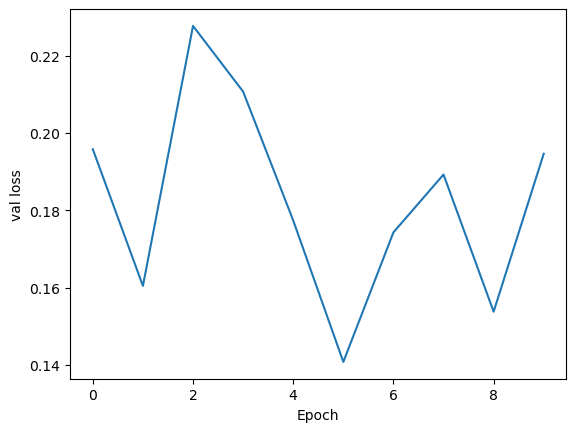

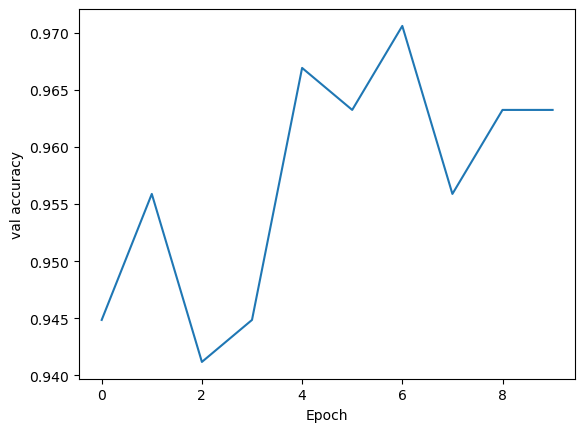

In [14]:
for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.xlabel('Epoch')
        plt.ylabel(f'{phase} {metric}')
        plt.show()

# Testing

In [15]:
preds = []
actual = []

tot_loss = tot_acc = count = 0

for images, labels in tqdm(dataloaders['test']):
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES)
        out_labels = torch.argmax(output, dim=1)


        tot_loss += criterion(output, ohe_label.float().to(device))
        tot_acc += (labels.to(device) == out_labels).sum()/len(labels)
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")

100%|██████████| 34/34 [00:03<00:00, 10.29it/s]

Test Loss: 0.2125997394323349, Test Accuracy: 0.9705882668495178


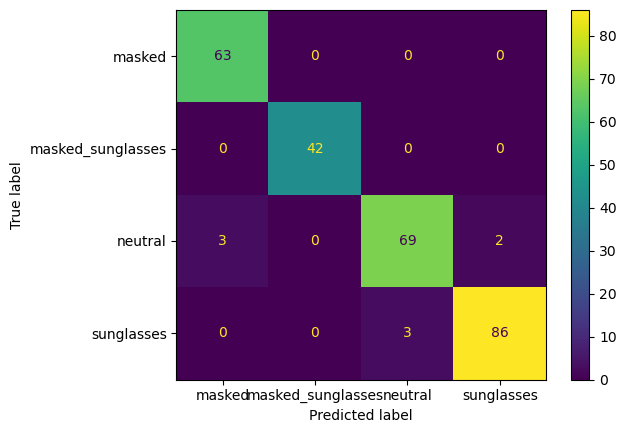

In [16]:
class_labels = sorted(dataset.class_lbl.keys())

cm = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()
plt.show()

In [17]:
cm_np = np.array(cm)
stats = pd.DataFrame(index=class_labels)
stats['Precision'] = [cm_np[i, i]/np.sum(cm_np[:, i]) for i in range(len(cm_np))]
stats['Recall'] = [cm_np[i, i]/np.sum(cm_np[i, :]) for i in range(len(cm_np))]

In [18]:
stats

,Precision,Recall
masked,0.954545,1.000000
masked_sunglasses,1.000000,1.000000
neutral,0.958333,0.932432
sunglasses,0.977273,0.966292


# Inference

In [24]:
model_infer = torch.load("model_4.pth")

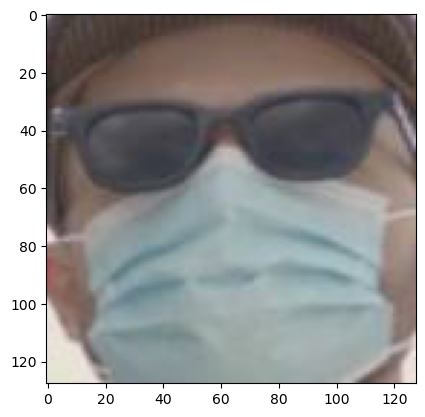

Image class:  masked_sunglasses


In [32]:

img_infer = read_image("../Face_detection/detected/masked_sunglasses/16.jpg", ImageReadMode.RGB).float()
img = plt.imread("../Face_detection/detected/masked_sunglasses/16.jpg")
imgplot = plt.imshow(img)
plt.show()

img_infer = img_infer[None, :, : , :]
# assert img_infer.shape == ()
result = model_infer(img_infer.to(device))
out_label = torch.argmax(result, dim=1)

out = out_label.cpu().detach().numpy()
for key, val in dataset.class_lbl.items():
    if(val == out[0]): 
        print("Image class: ", key)